In [ ]:
#Load libraries essential for NLP 
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#The objective of this project is to analyze Twitter Customer Support dataset leveraging NLP techniques .
#It will primarily focus on @AppleSupport
CST = pd.read_csv('/content/sample_data/twcs.csv', nrows = 200000,)
CST.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0


In [ ]:
#Apple subset
AppleSupport = ['AppleSupport']

#Create dataframe with Apple related data point
Apple = CST[CST['author_id'].isin(AppleSupport) | CST['text'].str.contains('AppleSupport')] 
Apple.reset_index(drop = True, inplace= True)

#Check changes
Apple.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0
1,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0


In [ ]:
#Convert 'created_at' to date timestamp and create Year, Month, Day columns
Apple['created_at'] = Apple['created_at'].astype('datetime64[ns]')
Apple['Year'] = pd.DatetimeIndex(Apple['created_at']).year
Apple['Month'] = pd.DatetimeIndex(Apple['created_at']).month
Apple['Day'] =  pd.DatetimeIndex(Apple['created_at']).day
Apple['Hour_Created'] = Apple.created_at.dt.hour

#Drop 'created_at column
Apple.drop(["created_at"], axis=1, inplace=True)

#Change 'text' to type string
Apple['text'] = Apple['text'].astype(str)

In [ ]:
pip install emoji --upgrade

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.6.0)


In [ ]:
#Function to remove twitter @handles and url's
import re
import emoji

def preprocess(text):
  
  text = re.sub('(@\S*)','', text)
  text = re.sub('https\S*', '', text)
  
  return text

In [ ]:
#Check changes
Apple.head(2)

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,Year,Month,Day,Hour_Created
0,696,AppleSupport,False,@115854 We're here for you. Which version of t...,697,698.0,2017,10,31,22
1,697,115854,True,@AppleSupport The newest update. I️ made sure ...,699,696.0,2017,10,31,22


In [ ]:
#Apply preprocess function
#Create new column with clean text

Apple['Clean_text'] = Apple['text'].apply(preprocess)

#Convert emoji's into text
Apple["Clean_text"] = Apple['Clean_text'].apply(lambda x : emoji.demojize( x, delimiters=('', '')))

#Test if emoji transformations are successful
Apple.iloc[38 , 3]
print('\n')
Apple.iloc[38 , 10]

'@AppleSupport Okey. Thank you! 🤗'

' Okey. Thank you! hugging_face'

In [ ]:
#Test if link transformations are successful
Apple.iloc[4 , 3]
print('\n')
Apple.iloc[4 , 10]

'@AppleSupport why are my I️’s changing not showing up correctly on any of my social media platforms? https://t.co/GyRvpyVnkE'

' why are my I’s changing not showing up correctly on any of my social media platforms? '

In [ ]:
from nltk.corpus import stopwords 

#Count Vectorizer
vectorizer = CountVectorizer(stop_words = 'english', min_df = 6)
Apple_text_vectorized = vectorizer.fit_transform(Apple['Clean_text'])
Apple_text_vectorized.shape

(10843, 1563)

In [ ]:
Apple_words = pd.DataFrame(Apple_text_vectorized.toarray(),columns = vectorizer.get_feature_names())
Apple_words.head(2)

,000,01,02,03,10,100,11,12,13,14,15,15b202,16,20,2012,2015,2017,24,25,2nd,30,3d,3rd,3x,40,50,5am,5k,5s,60,6s,70,7plus,80,800,8pm,99,able,absolute,absolutely,...,wife,wifi,window,windows,wiped,wireless,wish,won,wonderful,wondering,wont,word,words,work,worked,working,workout,works,worries,worse,worst,worth,wouldn,wow,write,writing,wrong,wtf,ya,yea,yeah,year,years,yep,yes,yesterday,yo,youtube,yup,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


array([88.4938773 , 59.06029992, 49.20291153, 46.04864525, 43.76399491,
       43.10363088, 37.58025842, 33.98098138, 32.14924766, 31.72186044,
       31.15070468, 30.62098787, 30.57914595, 29.21375867, 28.35684205])

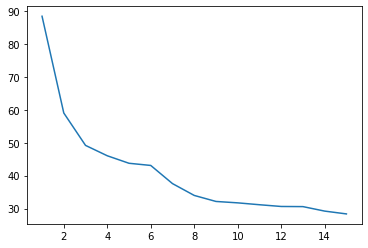

In [ ]:
#Creating a randomized_svd
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(Apple_text_vectorized, n_components=15,
                                      n_iter=5,
                                      random_state=None)

#Sigma array
Sigma

#Plot Sigma results
plt.plot(range(1,16),Sigma)
plt.show()

In [ ]:
#NMF topic model
from sklearn.decomposition import NMF

#Creating model for 8 topics
nmf_model = NMF(8)
Apple_topics = nmf_model.fit_transform(Apple_text_vectorized)

In [ ]:
#Arg sort on components
words = vectorizer.get_feature_names()

t = nmf_model.components_.argsort(axis=1)[:,-1:-8:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['dm', 'll', 'look', 'send', 'like', 'continue', 'happy'],
 ['gt', 'version', 'settings', 'general', 'ios', 'running', 'check'],
 ['ios', '11', 'version', 'updated', 'battery', 'device', 'running'],
 ['help', 'want', 'support', 'like', 'device', 'happy', 'twitter'],
 ['let', 'know', 'dm', 'steps', 'device', 'issue', 'using'],
 ['iphone', 'battery', 'new', 'using', 'want', '6s', 'plus'],
 ['update', 'phone', 'new', 'just', 'issue', 've', 'battery'],
 ['apple', 'music', 'app', 'thanks', 'store', 'just', 'watch']]

In [ ]:
#Function to label topics
def display_topics(model, feature_names, no_top_words, topic_names= ['Apple Resolution Attempts','iOS Status','Functionality Inquiries','Communication Preference','Troubleshoot','iPhone Support','General Inquiries','Application Support']):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
#Display topics with respective words
display_topics(nmf_model, vectorizer.get_feature_names(), 30)


Topic: ' Apple Resolution Attempts '
dm, ll, look, send, like, continue, happy, thanks, started, meet, details, country, closer, link, reaching, using, version, reach, information, issue, assist, want, work, working, located, options, going, ve, experiencing, thank

Topic: ' iOS Status '
gt, version, settings, general, ios, running, check, using, currently, installed, device, software, tell, happy, exact, start, tap, look, want, keyboard, going, assist, locate, tapping, sure, love, current, make, apps, reset

Topic: ' Functionality Inquiries '
ios, 11, version, updated, battery, device, running, updating, using, issue, currently, installed, released, 10, latest, fix, 6s, life, started, ipad, issues, current, recently, wi, sure, fi, bluetooth, exact, control, bug

Topic: ' Communication Preference '
help, want, support, like, device, happy, twitter, english, offer, love, version, contact, tell, join, start, need, using, issues, language, article, preferred, steps, issue, having, reachi

In [ ]:
#Loop through list components for topics
Topic_list = ['Apple Resolution Attempts','iOS Status','Functionality Inquiries','Communication Preference','Troubleshoot','iPhone Support','General Inquiries','Application Support']
Apple['topics'] = [Topic_list[i] for i in Apple_topics.argmax(axis = 1)]
Apple.head(2)

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,Year,Month,Day,Hour_Created,Clean_text,topics
0,696,AppleSupport,False,@115854 We're here for you. Which version of t...,697,698.0,2017,10,31,22,We're here for you. Which version of the iOS ...,iOS Status
1,697,115854,True,@AppleSupport The newest update. I️ made sure ...,699,696.0,2017,10,31,22,The newest update. I made sure to download it...,General Inquiries


In [ ]:
pip install vaderSentiment

In [ ]:
#Create sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

Apple['Sentiment'] = Apple['Clean_text'].apply(lambda Text: analyzer.polarity_scores(Text))

In [ ]:
#Create respective sentiment columns
Apple['Sentiment_negative'] = Apple['Sentiment'].apply(lambda x: x['neg'])
Apple['Sentiment_neutral'] = Apple['Sentiment'].apply(lambda x: x['neu'])
Apple['Sentiment_positive'] = Apple['Sentiment'].apply(lambda x: x['pos'])
Apple['Sentiment_compound'] = Apple['Sentiment'].apply(lambda x: x['compound'])

In [ ]:
#Drop null values
Apple.dropna(inplace=True)

#Check changes
Apple.head(4)

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,Year,Month,Day,Hour_Created,Clean_text,topics,Sentiment,Sentiment_negative,Sentiment_neutral,Sentiment_positive,Sentiment_compound
0,696,AppleSupport,False,@115854 We're here for you. Which version of t...,697,698.0,2017,10,31,22,We're here for you. Which version of the iOS ...,iOS Status,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000
1,697,115854,True,@AppleSupport The newest update. I️ made sure ...,699,696.0,2017,10,31,22,The newest update. I made sure to download it...,General Inquiries,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.0,0.796,0.204,0.3182
3,698,115854,True,@AppleSupport https://t.co/NV0yucs0lB,696,700.0,2017,10,31,22,,Apple Resolution Attempts,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,0.000,0.000,0.0000
6,702,115855,True,@AppleSupport Tried resetting my settings .. r...,701,703.0,2017,10,31,22,Tried resetting my settings .. restarting my ...,General Inquiries,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000


In [ ]:
#Excel export to create Tableau dashboard
Apple.to_excel("Apple_tweets.xlsx",
              sheet_name='Apple_tweets')

In [ ]:
pip install scattertext

     |████████████████████████████████| 7.2MB 2.8MB/s 


In [ ]:
#Building scattertext
import scattertext as st

corpus = st.CorpusFromPandas(Apple,
                             category_col='author_id',
                             text_col= 'Clean_text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [ ]:
#Generate url for scattertext
html = st.produce_scattertext_explorer(
        corpus,
        category='AppleSupport',
        category_name='AppleSupport',
        not_category_name='Customer Inquires',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000
        )

open('Apple.html', 'wb').write(html.encode('utf-8'));